In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, roc_curve

In [45]:
google_train = pd.read_csv('./data_preprocess_v3/train_google.csv')
google_test = pd.read_csv('./data_preprocess_v3/test_google.csv')
mic_train = pd.read_csv('./data_preprocess_v3/train_microsoft.csv')
mic_test = pd.read_csv('./data_preprocess_v3/test_microsoft.csv')
apple_train = pd.read_csv('./data_preprocess_v3/train_apple.csv')
apple_test = pd.read_csv('./data_preprocess_v3/test_apple.csv')

train_data = pd.concat([google_train,mic_train,apple_train], ignore_index=True)
test_data = pd.concat([google_test,mic_test,apple_test], ignore_index=True)

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_mov = train_data["movement"]
test_mov = test_data["movement"]
train_data = scaler.fit_transform(train_data.drop(["movement"],1))
test_data = scaler.fit_transform(test_data.drop(["movement"],1))
train_data["movement"] = train_mov
test_data["movement"] = test_mov

In [48]:
train = train_data.drop(["Close (t)","movement"],1)
label_train = train_data["Close (t)"]
test = test_data.drop(["Close (t)","movement"],1)
label_test = test_data["Close (t)"]

In [49]:
def evaluate(test, label_test):
    predicted = test
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))

    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
   
    print("f1", str(f1_score(label_test, predicted, average='weighted')))
    
    print("metrics.roc_auc_score", str(roc_auc_score(label_test, predicted, average='weighted')))

    cm = confusion_matrix(label_test, predicted)
    f = sns.heatmap(cm, annot=True, fmt='d')
    
    classification = classification_report(label_test, predicted)
    print(classification)

Decision Tree

In [50]:
dtr = DecisionTreeRegressor()
DecisionTreeRegressor(ccp_alpha= 0, criterion='mse', max_depth=6) 

DecisionTreeRegressor(ccp_alpha=0, max_depth=6)

In [51]:
dtr.fit(train, label_train)

score = dtr.score(train, label_train)
print("R-squared:", score) 

ypred = dtr.predict(test)
ypred = scaler.inverse_transform(ypred)
mse = mean_squared_error(label_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 1.0
MSE:  3.760767389456598e-09
RMSE:  1.880383694728299e-09


In [52]:
#Obtain new train movement label based on whether ypred close price at t > close price at t-1
ypred_train = dtr.predict(train)
ypred_train = scaler.inverse_transform(ypred_tra)
train_move = (ypred_train - train["Close (t-1)"])
train_move = train_move.where(train_move < 0, 1).where(train_move >= 0, 0).astype(int)
label_train_move = train_data["movement"]
test_move = (ypred - test["Close (t-1)"])
test_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
label_test_move = test_data["movement"]

accuracy: 0.9994372537985369
precision: 0.9994378199415968
recall: 0.9994372537985369
f1 0.9994372158438858
metrics.roc_auc_score 0.9993622448979591
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       784
           1       1.00      1.00      1.00       993

    accuracy                           1.00      1777
   macro avg       1.00      1.00      1.00      1777
weighted avg       1.00      1.00      1.00      1777

accuracy: 0.45609436435124506
precision: 0.5095790044730342
recall: 0.45609436435124506
f1 0.4477215811113833
metrics.roc_auc_score 0.4893623134274755
              precision    recall  f1-score   support

           0       0.39      0.65      0.49       302
           1       0.59      0.33      0.42       461

    accuracy                           0.46       763
   macro avg       0.49      0.49      0.45       763
weighted avg       0.51      0.46      0.45       763



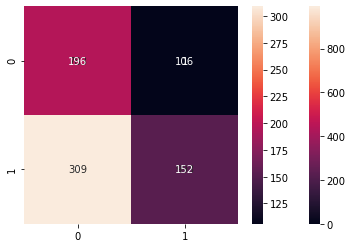

In [53]:
metric_train = evaluate(train_move, label_train_move)
metric_test = evaluate(test_move, label_test_move)

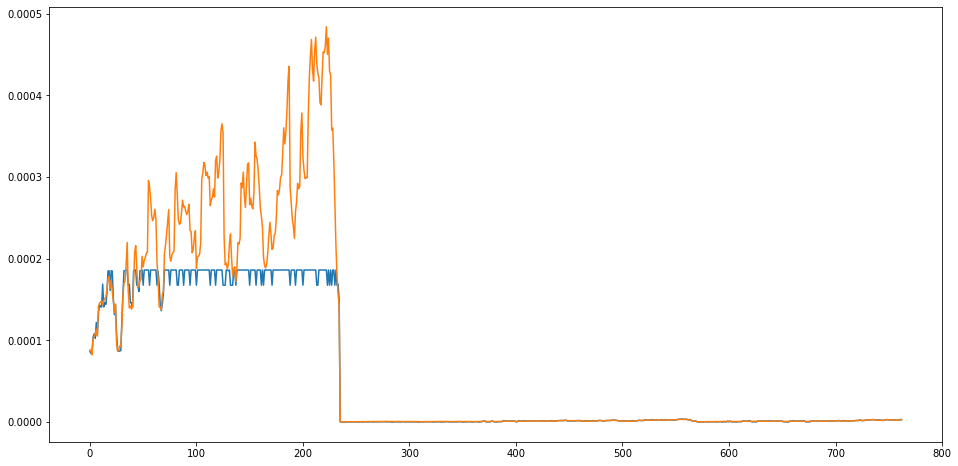

In [54]:
plt.figure(figsize=(16,8))
plt.plot(ypred)
plt.plot(label_test)

Gradient Boosting

In [55]:
gb = GradientBoostingRegressor()
GradientBoostingRegressor(ccp_alpha= 0, criterion='mse', max_depth=6) 

GradientBoostingRegressor(ccp_alpha=0, criterion='mse', max_depth=6)

In [56]:
gb.fit(train, label_train)

score = gb.score(train, label_train)
print("R-squared:", score) 

ypred = gb.predict(test)
mse = mean_squared_error(label_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 0.9998902704188227
MSE:  3.657416188879932e-09
RMSE:  1.828708094439966e-09


In [57]:
#Obtain new train movement label based on whether ypred close price at t > close price at t-1
ypred_train = gb.predict(train)
train_move = (ypred_train - train["Close (t-1)"])
train_move = train_move.where(train_move < 0, 1).where(train_move >= 0, 0).astype(int)
label_train_move = train_data["movement"]
test_move = (ypred - test["Close (t-1)"])
test_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
label_test_move = test_data["movement"]

accuracy: 0.5678109172763084
precision: 0.5716970488069802
recall: 0.5678109172763084
f1 0.5690669187366938
metrics.roc_auc_score 0.5659097098053724
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       784
           1       0.62      0.58      0.60       993

    accuracy                           0.57      1777
   macro avg       0.57      0.57      0.56      1777
weighted avg       0.57      0.57      0.57      1777

accuracy: 0.436435124508519
precision: 0.48589724343328544
recall: 0.436435124508519
f1 0.42799990857848214
metrics.roc_auc_score 0.4685250894255219
              precision    recall  f1-score   support

           0       0.37      0.62      0.47       302
           1       0.56      0.31      0.40       461

    accuracy                           0.44       763
   macro avg       0.47      0.47      0.43       763
weighted avg       0.49      0.44      0.43       763



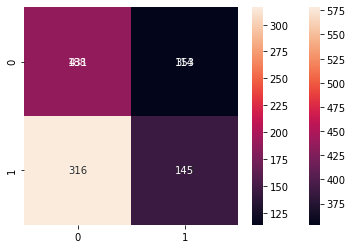

In [58]:
metric_train = evaluate(train_move, label_train_move)
metric_test = evaluate(test_move, label_test_move)

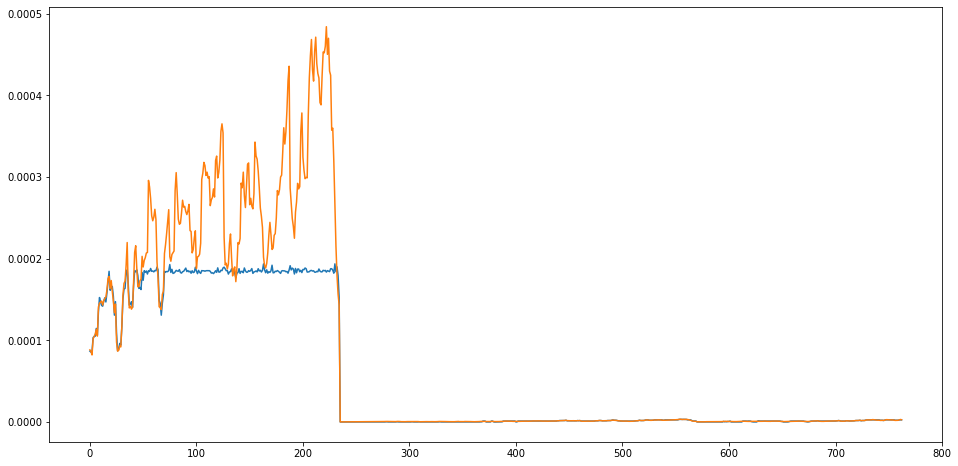

In [59]:
plt.figure(figsize=(16,8))
plt.plot(ypred)
plt.plot(label_test)

Random Forest

In [60]:
rfc = RandomForestRegressor()
RandomForestRegressor(ccp_alpha= 0, criterion='mse', max_depth=6) 

RandomForestRegressor(ccp_alpha=0, max_depth=6)

In [61]:
rfc.fit(train, label_train)

score = rfc.score(train, label_train)
print("R-squared:", score) 

ypred = rfc.predict(test)
mse = mean_squared_error(label_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 0.9996884205210993
MSE:  3.799362217361934e-09
RMSE:  1.899681108680967e-09


In [62]:
#Obtain new train movement label based on whether ypred close price at t > close price at t-1
ypred_train = rfc.predict(train)
train_move = (ypred_train - train["Close (t-1)"])
train_move = train_move.where(train_move < 0, 1).where(train_move >= 0, 0).astype(int)
label_train_move = train_data["movement"]
test_move = (ypred - test["Close (t-1)"])
test_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
label_test_move = test_data["movement"]

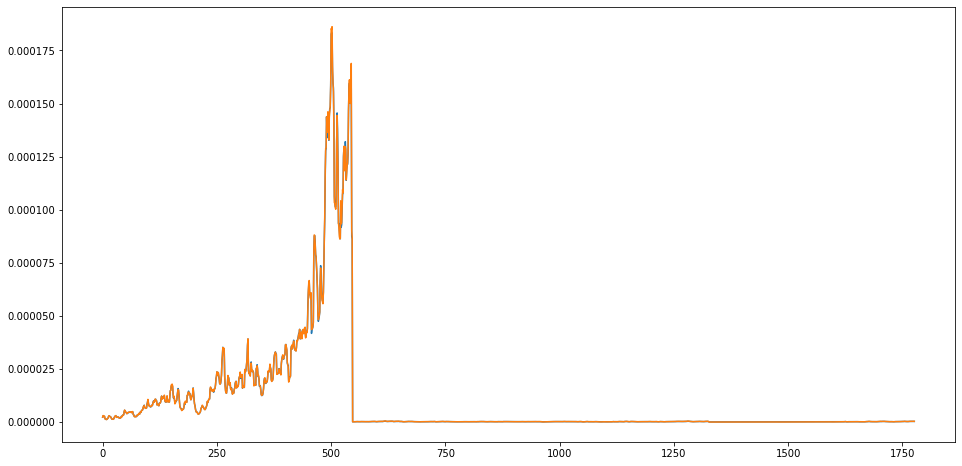

In [70]:
plt.figure(figsize=(16,8))
plt.plot(ypred_train)
plt.plot(label_train)

In [64]:
p = pd.concat([pd.DataFrame(ypred_train), train["Close (t-1)"], train_move], axis = 1)
p.columns = ["close (t)", "close(t-1)", "movement"]
p

,close (t),close(t-1),movement
0,2.313021e-06,2.181406e-06,1
1,2.948054e-06,2.810146e-06,1
2,2.697244e-06,2.669853e-06,1
3,2.613105e-06,2.508928e-06,1
4,2.671168e-06,2.254731e-06,1
...,...,...,...
1772,3.328926e-07,4.116828e-07,0
1773,3.295895e-07,3.964776e-07,0
1774,3.039097e-07,3.544234e-07,0
1775,3.026942e-07,3.608783e-07,0


In [65]:
a = pd.concat([label_train, train["Close (t-1)"], train_data["movement"]], axis = 1)
a.columns = ["close (t)", "close(t-1)", "movement"]
a

,close (t),close(t-1),movement
0,2.297989e-06,2.181406e-06,1
1,3.063073e-06,2.810146e-06,1
2,2.714289e-06,2.669853e-06,1
3,2.645685e-06,2.508928e-06,1
4,2.840157e-06,2.254731e-06,1
...,...,...,...
1772,4.078514e-07,4.116828e-07,0
1773,3.922237e-07,3.964776e-07,0
1774,3.592714e-07,3.544234e-07,1
1775,3.498637e-07,3.608783e-07,0


In [66]:
comb = p.merge(a, left_on = "close(t-1)", right_on = "close(t-1)")
len(comb[comb["movement_x"] == comb["movement_y"]])
len(a)

1777

accuracy: 0.6477208778840743
precision: 0.6517639647779859
recall: 0.6477208778840743
f1 0.6487973010323107
metrics.roc_auc_score 0.6473432651006021
              precision    recall  f1-score   support

           0       0.59      0.64      0.62       784
           1       0.70      0.65      0.67       993

    accuracy                           0.65      1777
   macro avg       0.65      0.65      0.65      1777
weighted avg       0.65      0.65      0.65      1777

accuracy: 0.44692005242463956
precision: 0.4983697421443162
recall: 0.44692005242463956
f1 0.4386417707444638
metrics.roc_auc_score 0.4794860007757395
              precision    recall  f1-score   support

           0       0.38      0.64      0.48       302
           1       0.58      0.32      0.41       461

    accuracy                           0.45       763
   macro avg       0.48      0.48      0.45       763
weighted avg       0.50      0.45      0.44       763



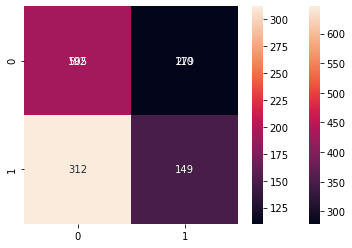

In [67]:
metric_train = evaluate(train_move, label_train_move)
metric_test = evaluate(test_move, label_test_move)